# **Capstone Project - Car accident severity**

## 1) Introduction/Business Problem

#####  Task: Clearly define a problem or an idea of your choice. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

The aim of this study is to predict the severity of a car accident. This would be a tool that, given the weather, the road conditions and other variables, could warn surrounding hospitals about the possibility of getting a severe and be prepared for it. It would also warn people to drive more carefully or even change their travel if they are able to.


In order to study this problem, I used the dataset given in the Coursera Capstone project: Data-Collisions.csv that contains Data of collisions in Seattle.

## 2) Data

##### Task: Describe the data that you will be using to solve the problem or execute your idea. So make sure that you provide adequate explanation and discussion, with examples, of the data that you will be using.

In [76]:
# importing the modules I will need
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing,metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score,jaccard_similarity_score,log_loss
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [77]:
# uploding the dataset
df=pd.read_csv('Data-Collisions.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's take a look at the database. 

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

'SEVERITYCODE' is our target label. Let's analyse it.

In [79]:
df['SEVERITYCODE'].head()

0    2
1    1
2    1
3    1
4    2
Name: SEVERITYCODE, dtype: int64

In [80]:
df['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

We have just two classes. This will simplify our job with the classifier later. However, in the meta data there is an explanation for the severity code:

1) property damage

2) injury


Now let's analyse the features and select the ones that are appropriate for the problem. In order to be suitable for classification problems, features should be categorical variables. In case we have some useful feature that is not categorical, we could still get dunny variables from them, so we do not exclude non-categorical variables a priori.

Let's start with variables that refers to the location of the accident.

In [81]:
df[['X','Y','LOCATION']]

,X,Y,LOCATION
0,-122.323148,47.703140,5TH AVE NE AND NE 103RD ST
1,-122.347294,47.647172,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N
2,-122.334540,47.607871,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST
3,-122.334803,47.604803,2ND AVE BETWEEN MARION ST AND MADISON ST
4,-122.306426,47.545739,SWIFT AVE S AND SWIFT AV OFF RP
...,...,...,...
194668,-122.290826,47.565408,34TH AVE S BETWEEN S DAKOTA ST AND S GENESEE ST
194669,-122.344526,47.690924,AURORA AVE N BETWEEN N 85TH ST AND N 86TH ST
194670,-122.306689,47.683047,20TH AVE NE AND NE 75TH ST
194671,-122.355317,47.678734,GREENWOOD AVE N AND N 68TH ST


'LOCATION' is text about where the car accident happened not good as categorical variable and since it is a description of two streets, not good to be transformed as dummy variable. 'X','Y' are coordinates. We could retrieve the district of the city with geopy and give a dummy variable to each district. Let's try:

In [82]:
!pip install geopy

In [83]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')
a = locator.reverse('47.703140,-122.323148')
a

Location(Thornton Creek Apartments, 514, Northeast 103rd Street, Licton Springs, Maple Leaf, Seattle, King County, Washington, 98125, United States of America, (47.7033299, -122.3220510871665, 0.0))

The problem is again that accident can happen in between two disctrits as in the example: Licton Springs and Maple Leaf. This is not a good variable to be transformed into a dummy one, since it would be a combination of 2 or more variables (i.e. the districts). We could still separate the city in north and south (or East and West) with the coordinates. In case I would have some time left I will try it. For now, we drop 'X', 'Y' and 'LOCATION'.

In [84]:
df.drop(['X', 'Y', 'LOCATION'], axis=1, inplace=True)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 35 columns):
SEVERITYCODE      194673 non-null int64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
SDOT_COLCODE      194673 non-null int64
SDOT_COLDESC      194673 non-null object


Next variables 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO' are just codes and we discard them.

In [86]:
df.drop(['OBJECTID', 'INCKEY', 'COLDETKEY','REPORTNO'], axis=1, inplace=True)

In [87]:
df['STATUS'].value_counts()

Matched      189786
Unmatched      4887
Name: STATUS, dtype: int64

'STATUS' is not described into the meta data and I frankly do not have any idea what it refers to, so I discard this too.

In [88]:
df.drop(['STATUS'], axis=1, inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 30 columns):
SEVERITYCODE      194673 non-null int64
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
SDOT_COLCODE      194673 non-null int64
SDOT_COLDESC      194673 non-null object
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null objec

In [90]:
df['ADDRTYPE'].value_counts()

Block           126926
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

'ADDRTYPE' looks like a good variable, but contains redoundand information that are already reported in 'SDOT_COLCODE'. The next 'INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC' are codes or not valuable info. 'SEVERITYCODE.1' looks like a copy of 'SEVERITYCODE' and 'SEVERITYDESC' contains the same info, but in a text format. We discard all this columns.

In [91]:
df.drop(['ADDRTYPE','INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC','SEVERITYCODE.1','SEVERITYDESC'], axis=1, inplace=True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 24 columns):
SEVERITYCODE      194673 non-null int64
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
SDOT_COLCODE      194673 non-null int64
SDOT_COLDESC      194673 non-null object
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     4667 non-null object
SDOTCOLNUM        114936 non-null float64
SPEEDING          9333 non-null object
ST_COLCODE        194655 non-null object
ST_COLDESC        189769 non-null object
SEGLANEKEY        194673 non-null int6

In [93]:
df['COLLISIONTYPE'].value_counts()

Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
Right Turn     2956
Head On        2024
Name: COLLISIONTYPE, dtype: int64

The info in 'COLLISIONTYPE' are also contained in 'SDOT_COLCODE', so I am gonna discard it. We keep 'PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT' that are good categorical variables.

In [94]:
df.drop(['COLLISIONTYPE'], axis=1, inplace=True)

In [95]:
df[['INCDATE','INCDTTM']]

,INCDATE,INCDTTM
0,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM
...,...,...
194668,2018/11/12 00:00:00+00,11/12/2018 8:12:00 AM
194669,2018/12/18 00:00:00+00,12/18/2018 9:14:00 AM
194670,2019/01/19 00:00:00+00,1/19/2019 9:25:00 AM
194671,2019/01/15 00:00:00+00,1/15/2019 4:48:00 PM


'INCDATE' and 'INCDTTM' reports the time and date of the accident. We keep 'INCDTTM' since it is more complete and discrd 'INCDATE'.

In [96]:
df.drop(['INCDATE'], axis=1, inplace=True)

In [97]:
df['JUNCTIONTYPE'].value_counts()

Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Unknown                                                  9
Name: JUNCTIONTYPE, dtype: int64

We discard 'JUNCTIONTYPE' and 'SDOT_COLDESC' and keep 'SDOT_COLCODE' that describe the accident with a code.

In [98]:
df['SDOT_COLDESC'].value_counts()

MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE          85209
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END                    54299
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE          9928
NOT ENOUGH INFORMATION / NOT APPLICABLE                          9787
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT                    8856
MOTOR VEHCILE STRUCK PEDESTRIAN                                  6518
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE           5852
MOTOR VEHICLE STRUCK OBJECT IN ROAD                              4741
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE            3104
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE         1604
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE          1440
PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ANGLE             1312
MOTOR VEHICLE OVERTURNED IN ROAD                                  479
MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END                       181
PEDALCYCLIST STRUCK 

In [99]:
df.drop(['SDOT_COLDESC','JUNCTIONTYPE'], axis=1, inplace=True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 20 columns):
SEVERITYCODE      194673 non-null int64
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDTTM           194673 non-null object
SDOT_COLCODE      194673 non-null int64
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     4667 non-null object
SDOTCOLNUM        114936 non-null float64
SPEEDING          9333 non-null object
ST_COLCODE        194655 non-null object
ST_COLDESC        189769 non-null object
SEGLANEKEY        194673 non-null int64
CROSSWALKKEY      194673 non-null int64
HITPARKEDCAR      194673 non-null object
dtypes: float64(1), int64(8), object(11)
memory usage: 29.7+ MB


We keep 'INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT' and 'SPEEDING'. We discard 'HITPARKEDCAR','SEGLANEKEY','CROSSWALKKEY','SDOTCOLNUM' and 'ST_COLCODE','ST_COLDESC' since they have similar information of 'SDOT_COLCODE'.

In [101]:
df.drop(['HITPARKEDCAR','SEGLANEKEY','CROSSWALKKEY','SDOTCOLNUM','ST_COLCODE','ST_COLDESC'], axis=1, inplace=True)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 14 columns):
SEVERITYCODE      194673 non-null int64
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDTTM           194673 non-null object
SDOT_COLCODE      194673 non-null int64
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     4667 non-null object
SPEEDING          9333 non-null object
dtypes: int64(6), object(8)
memory usage: 20.8+ MB


We convert object-type columns in categorical variables. We fill the NaNs with zero, since if it is note annotated as INATTENTIONIN, it is probably not the cause of the accident. We do the same for 'UNDERINFL', 'PEDROWNOTGRNT' and 'SPEEDING'.

In [103]:
df['INATTENTIONIND']=df['INATTENTIONIND'].fillna(0)
df['INATTENTIONIND'].replace('Y',1, inplace=True)

In [104]:
df['INATTENTIONIND'].value_counts()

0    164868
1     29805
Name: INATTENTIONIND, dtype: int64

In [105]:
df['UNDERINFL'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [106]:
df['UNDERINFL'].replace('Y',1, inplace=True)
df['UNDERINFL'].replace('N',0, inplace=True)
df['UNDERINFL'].replace('1',1, inplace=True)
df['UNDERINFL'].replace('0',0, inplace=True)
df['UNDERINFL']=df['UNDERINFL'].fillna(0)
df['UNDERINFL']=df['UNDERINFL'].astype(int)

In [107]:
df['UNDERINFL'].value_counts()

0    185552
1      9121
Name: UNDERINFL, dtype: int64

In [108]:
df['PEDROWNOTGRNT'].value_counts()

Y    4667
Name: PEDROWNOTGRNT, dtype: int64

In [109]:
df['PEDROWNOTGRNT'].replace('Y',1, inplace=True)
df['PEDROWNOTGRNT']=df['PEDROWNOTGRNT'].fillna(0)
df['PEDROWNOTGRNT']=df['PEDROWNOTGRNT'].astype(int)

In [110]:
df['PEDROWNOTGRNT'].value_counts()

0    190006
1      4667
Name: PEDROWNOTGRNT, dtype: int64

In [111]:
df['SPEEDING'].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

In [112]:
df['SPEEDING'].replace('Y',1, inplace=True)
df['SPEEDING']=df['SPEEDING'].fillna(0)

In [113]:
df['SPEEDING'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SPEEDING, dtype: float64

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 14 columns):
SEVERITYCODE      194673 non-null int64
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDTTM           194673 non-null object
SDOT_COLCODE      194673 non-null int64
INATTENTIONIND    194673 non-null int64
UNDERINFL         194673 non-null int64
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     194673 non-null int64
SPEEDING          194673 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 20.8+ MB


We notice that 'ROADCOND', 'LIGHTCOND' and 'WEATHER' do not have all the data. Wi will fill the missing data with the most frequent.

In [115]:
df['ROADCOND']=df['ROADCOND'].fillna(df['ROADCOND'].mode().iloc[0])
df['ROADCOND'].value_counts()

Dry               129522
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64

In [116]:
df['LIGHTCOND']=df['LIGHTCOND'].fillna(df['LIGHTCOND'].mode().iloc[0])
df['LIGHTCOND'].value_counts()

Daylight                    121307
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [117]:
df['WEATHER']=df['WEATHER'].fillna(df['WEATHER'].mode().iloc[0])
df['WEATHER'].value_counts()

Clear                       116216
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 14 columns):
SEVERITYCODE      194673 non-null int64
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDTTM           194673 non-null object
SDOT_COLCODE      194673 non-null int64
INATTENTIONIND    194673 non-null int64
UNDERINFL         194673 non-null int64
WEATHER           194673 non-null object
ROADCOND          194673 non-null object
LIGHTCOND         194673 non-null object
PEDROWNOTGRNT     194673 non-null int64
SPEEDING          194673 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 20.8+ MB


I will deal with the non-categorical variables in the EDA section.

## 3) Metodology 

##### Task: Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

In [119]:
import datetime as dt

Let's analyse the date-time feature.

In [120]:
Feature=df[['INCDTTM','SEVERITYCODE']]
Feature = Feature.rename(columns={'INCDTTM': 'DATE'})
Feature['DATE']=pd.to_datetime(Feature['DATE'])
print(Feature.head())
print(df['INCDTTM'].head())

                 DATE  SEVERITYCODE
0 2013-03-27 14:54:00             2
1 2006-12-20 18:55:00             1
2 2004-11-18 10:20:00             1
3 2013-03-29 09:26:00             1
4 2004-01-28 08:04:00             2
0      3/27/2013 2:54:00 PM
1     12/20/2006 6:55:00 PM
2    11/18/2004 10:20:00 AM
3      3/29/2013 9:26:00 AM
4      1/28/2004 8:04:00 AM
Name: INCDTTM, dtype: object


In [121]:
Feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 2 columns):
DATE            194673 non-null datetime64[ns]
SEVERITYCODE    194673 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 MB


In [122]:
Feature['weekday'] = Feature['DATE'].dt.weekday

In [123]:
Feature.head()

,DATE,SEVERITYCODE,weekday
0,2013-03-27 14:54:00,2,2
1,2006-12-20 18:55:00,1,2
2,2004-11-18 10:20:00,1,3
3,2013-03-29 09:26:00,1,4
4,2004-01-28 08:04:00,2,2


In [124]:
Feature.groupby(['weekday'])['SEVERITYCODE'].value_counts()

weekday  SEVERITYCODE
0        1               18365
         2                7973
1        1               19825
         2                8731
2        1               20021
         2                8757
3        1               20306
         2                9018
4        1               22774
         2                9559
5        1               19342
         2                8047
6        1               15852
         2                6103
Name: SEVERITYCODE, dtype: int64

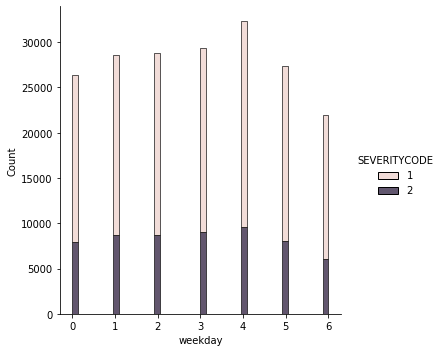

In [125]:
sns.displot(Feature, x="weekday", hue="SEVERITYCODE", multiple="stack")
plt.show()

In [126]:
Feature['day'] = Feature['DATE'].dt.hour
Feature['day']

0         14
1         18
2         10
3          9
4          8
          ..
194668     8
194669     9
194670     9
194671    16
194672    15
Name: day, Length: 194673, dtype: int64

I divide the day in Night = 0-6, Morning 6-12, Afternoon 12-18 and Evening 18-24. 

In [127]:
Feature['day'] = Feature['day'].apply(lambda x: 0 if x< 6 else (1 if 6<=x<12 else (2 if 12<=x<18 else 3)))
print(Feature['day'].head())
print(Feature['day'].value_counts())

0    2
1    3
2    1
3    1
4    1
Name: day, dtype: int64
2    67801
0    45949
1    42038
3    38885
Name: day, dtype: int64


In [128]:
Feature.head()

,DATE,SEVERITYCODE,weekday,day
0,2013-03-27 14:54:00,2,2,2
1,2006-12-20 18:55:00,1,2,3
2,2004-11-18 10:20:00,1,3,1
3,2013-03-29 09:26:00,1,4,1
4,2004-01-28 08:04:00,2,2,1


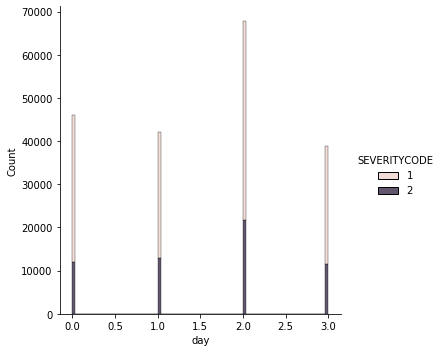

In [129]:
sns.displot(Feature, x="day", hue="SEVERITYCODE", multiple="stack")
plt.show()

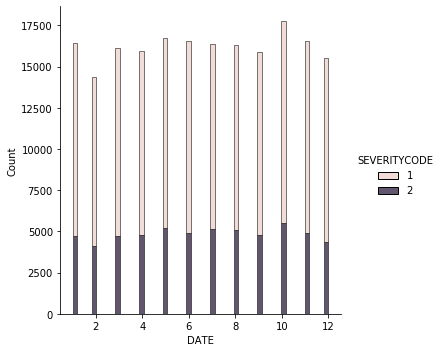

In [130]:
sns.displot(Feature, x=Feature['DATE'].dt.month, hue="SEVERITYCODE", multiple="stack")
plt.show()

In [131]:
Feature['month'] = Feature['DATE'].dt.month

We construct the dataframe "Feature" for the actual features I am gonna use. I also construct the dummy variables for the object type features.

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 14 columns):
SEVERITYCODE      194673 non-null int64
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDTTM           194673 non-null object
SDOT_COLCODE      194673 non-null int64
INATTENTIONIND    194673 non-null int64
UNDERINFL         194673 non-null int64
WEATHER           194673 non-null object
ROADCOND          194673 non-null object
LIGHTCOND         194673 non-null object
PEDROWNOTGRNT     194673 non-null int64
SPEEDING          194673 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 20.8+ MB


In [133]:
Feature.drop(['DATE','SEVERITYCODE'], axis = 1,inplace=True)
Feature['UNDERINFL']=df['UNDERINFL']
Feature['INATTENTIONIND']=df['INATTENTIONIND']
Feature['SPEEDING']=df['SPEEDING']
Feature['PERSONCOUNT']=df['PERSONCOUNT']
Feature['PEDCOUNT']=df['PEDCOUNT']
Feature['PEDCYLCOUNT']=df['PEDCYLCOUNT']
Feature['VEHCOUNT']=df['VEHCOUNT']
Feature['SDOT_COLCODE']=df['SDOT_COLCODE']
Feature['PEDROWNOTGRNT']=df['PEDROWNOTGRNT']
Feature['SPEEDING']=df['SPEEDING']
Feature = pd.concat([Feature,pd.get_dummies(df['WEATHER'])], axis=1)
Feature.drop(['Unknown'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(df['ROADCOND'])], axis=1)
Feature.drop(['Unknown'], axis = 1,inplace=True)
Feature = pd.concat([Feature,pd.get_dummies(df['LIGHTCOND'])], axis=1)
Feature.drop(['Unknown'], axis = 1,inplace=True)
Feature.head()

,weekday,day,month,UNDERINFL,INATTENTIONIND,SPEEDING,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other
0,2,2,3,0,0,0.0,2,0,0,2,...,0,1,0,0,0,0,0,1,0,0
1,2,3,12,0,0,0.0,2,0,0,2,...,0,1,0,0,1,0,0,0,0,0
2,3,1,11,0,0,0.0,4,0,0,3,...,0,0,0,0,0,0,0,1,0,0
3,4,1,3,0,0,0.0,3,0,0,3,...,0,0,0,0,0,0,0,1,0,0
4,2,1,1,0,0,0.0,2,0,0,2,...,0,1,0,0,0,0,0,1,0,0


In [134]:
X = Feature
X[0:5]

,weekday,day,month,UNDERINFL,INATTENTIONIND,SPEEDING,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dark - Unknown Lighting,Dawn,Daylight,Dusk,Other
0,2,2,3,0,0,0.0,2,0,0,2,...,0,1,0,0,0,0,0,1,0,0
1,2,3,12,0,0,0.0,2,0,0,2,...,0,1,0,0,1,0,0,0,0,0
2,3,1,11,0,0,0.0,4,0,0,3,...,0,0,0,0,0,0,0,1,0,0
3,4,1,3,0,0,0.0,3,0,0,3,...,0,0,0,0,0,0,0,1,0,0
4,2,1,1,0,0,0.0,2,0,0,2,...,0,1,0,0,0,0,0,1,0,0


In [135]:
y = df['SEVERITYCODE'].values
y[0:5]

array([2, 1, 1, 1, 2])

In [136]:
X= preprocessing.StandardScaler().fit(X).transform((X.astype(float)))
X[0:5]

array([[-0.49,  0.46, -1.03, -0.22, -0.43, -0.22, -0.33, -0.19, -0.17,
         0.13, -0.42, -0.16, -0.02, -1.22, -0.05, -0.07,  2.45, -0.01,
        -0.45, -0.01, -0.02, -0.07, -1.41, -0.08, -0.02, -0.03, -0.02,
        -0.07, -0.02,  1.76, -0.09, -0.08, -0.58, -0.01, -0.11,  0.78,
        -0.18, -0.03],
       [-0.49,  1.41,  1.59, -0.22, -0.43, -0.22, -0.33, -0.19, -0.17,
         0.13,  0.31, -0.16, -0.02, -1.22, -0.05, -0.07, -0.41, -0.01,
         2.21, -0.01, -0.02, -0.07, -1.41, -0.08, -0.02, -0.03, -0.02,
        -0.07, -0.02,  1.76, -0.09, -0.08,  1.74, -0.01, -0.11, -1.29,
        -0.18, -0.03],
       [ 0.03, -0.48,  1.3 , -0.22, -0.43, -0.22,  1.16, -0.19, -0.17,
         1.71,  0.02, -0.16, -0.02, -1.22, -0.05, -0.07,  2.45, -0.01,
        -0.45, -0.01, -0.02, -0.07,  0.71, -0.08, -0.02, -0.03, -0.02,
        -0.07, -0.02, -0.57, -0.09, -0.08, -0.58, -0.01, -0.11,  0.78,
        -0.18, -0.03],
       [ 0.55, -0.48, -1.03, -0.22, -0.43, -0.22,  0.41, -0.19, -0.17,
        

I decided to use the logistic regression model, since our target value is binary and it is much faster than the other classification models.

In [137]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136271, 38) (136271,)
Test set: (58402, 38) (58402,)


In [138]:
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
mean_acc = metrics.accuracy_score(y_test, yhat)

print(classification_report(y_test, yhat))
print("Mean Accuracy score: %.2f" %mean_acc)
print("F1-score: %.2f" %f1_score(y_test, yhat, average='weighted'))
print("Jaccard Similarity Score: %.2f" % jaccard_similarity_score(y_test, yhat))
yhat_prob = LR.predict_proba(X_test)
print("Log_Loss score: %.2f" %log_loss(y_test, yhat_prob))

              precision    recall  f1-score   support

           1       0.75      0.98      0.85     41083
           2       0.80      0.22      0.35     17319

    accuracy                           0.75     58402
   macro avg       0.78      0.60      0.60     58402
weighted avg       0.76      0.75      0.70     58402

Mean Accuracy score: 0.75
F1-score: 0.70
Jaccard Similarity Score: 0.75
Log_Loss score: 0.53


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


## 4) Results

##### Task: Results section where you discuss the results.

The model gives a good prediction given the features. I varied the c parameter in order to get the best result. For small datasets, ‘liblinear’ is a good choice for the solver, so I kept it that way. I tried to solve this problem also with KNN, but the computational time was terribly slow.

## 5) Discussion and conclusions

##### Task: Discussion section where you discuss any observations you noted and any recommendations you can make based on the results & Conclusion section where you conclude the report..

In this study I analysed the relationship between the severity of an accident and some features of the accident such as for example, light condition, weather, number of car involved, some causes of the accident like speeding.

I reached a good result with an accuracy of 0.75. this model could be very useful to alert hospitals that that day, in those particular conditions, it is expected a larger number of severe accidents and thay can prepare in advance toold and personals required.